In [2]:
# Importing necessary libraries

# Utility packages
import random
import pathlib
import numpy as np
import pandas as pd

# Torch + DL packages
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision.utils import make_grid
from IPython.display import HTML, display
from tqdm.notebook import tqdm, trange
import tensorflow as tf

# Miscellaneous packages
import os
from time import sleep
import seaborn as sns
import matplotlib.pyplot as plt
import xml.etree.cElementTree as et
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score, f1_score
from collections import defaultdict

In [3]:
# Figure Settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline 
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# It should print 'cuda', if not change your runtime to GPU.
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# mount drive to import data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
# reading the input files
training_df = pd.read_csv('/content/drive/MyDrive/CIS 522 Project/Cleaned Data/training_df.csv')
validation_df = pd.read_csv('/content/drive/MyDrive/CIS 522 Project/Cleaned Data/validation_df.csv')
testing_df = pd.read_csv('/content/drive/MyDrive/CIS 522 Project/Cleaned Data/testing_df.csv')

In [35]:
# replacing the null strings with empty strings
training_df = training_df.fillna('')
validation_df = validation_df.fillna('')
testing_df = testing_df.fillna('')

In [36]:
# over- and under-sampling to help address class imbalance
positive_samples = training_df.loc[training_df["Ground_Truth"] == 1]
negative_samples = training_df.loc[training_df["Ground_Truth"] == 0]
training_df = pd.concat([positive_samples, positive_samples, negative_samples.sample(frac=0.4)], ignore_index=True)

In [37]:
# splitting the data into text and labels
training_text = training_df['Comments'].values.tolist()
validation_text = validation_df['Comments'].values.tolist()
testing_text = testing_df['Comments'].values.tolist()

training_labels = torch.tensor(training_df['Ground_Truth'].values.tolist())
validation_labels = torch.tensor(validation_df['Ground_Truth'].values.tolist())
testing_labels = torch.tensor(testing_df['Ground_Truth'].values.tolist())

In [38]:
# creating features for text
tokenizer = TfidfVectorizer(use_idf=True, max_features=500)
tokenizer.fit_transform(training_text)

training_feature_set = tokenizer.transform(training_text)
validation_feature_set = tokenizer.transform(validation_text)
testing_feature_set = tokenizer.transform(testing_text)

In [39]:
# making custom dataset class to use data with loader
class CustomTextDataset(Dataset):
    def __init__(self, text_features, labels):
        self.text_features = text_features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text_features = self.text_features[idx].toarray()
        label = self.labels[idx]
        return text_features, label

In [40]:
# converting text features + labels into loader compatible dataset
training_data = CustomTextDataset(training_feature_set, training_labels)
validation_data = CustomTextDataset(validation_feature_set, validation_labels)
testing_data = CustomTextDataset(testing_feature_set, testing_labels)

In [41]:
# constructing the data loaders
BATCH_SIZE = 32
training_loader = torch.utils.data.DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
testing_loader = torch.utils.data.DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [42]:
def train(model, device, train_loader, validation_loader, epochs, criterion, optimizer):
  # Params:
  #   model-> instance of your model which extends nn.Module class
  #   device -> it is set to cuda already and is already stored in a variable called *device*
  #   train_loader -> dataloader for train dataset, already stored in a variable called *trainloader*
  #   validation_loader -> dataloader for validation dataset, already stored in a variable called *validationloader*
  #   epochs -> number of epochs for training, you are expected to experiment and play around with this
  #   criterion -> the loss function which you decide to use
  #   optimizer -> optimizer for your gradient descent, do not forget to set an appropriate learning rate
  #  Returns:  train_loss, train_f1, validation_loss, validation_f1, all of these are lists storing the values 

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []
    train_rec, validation_rec = [], []
    train_f1, validation_f1 = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        pred = torch.zeros((1, ), dtype=torch.int32).to(device)
        true = torch.zeros((1, ), dtype=torch.int32).to(device)

        # train on the train dataset
        with tqdm(train_loader, unit='batch') as tepoch:
            tepoch.set_description('Training: ')
            for data, target in tepoch:
                data, target = data.float().to(device), target.long().to(device)
                optimizer.zero_grad()
                output = model(data)
                
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                # get loss
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()
                
                # get predictions + labels
                _, predicted = torch.max(output, 1)
                true = torch.concat((true, target), axis=0)
                pred = torch.concat((pred, predicted), axis=0)
            
        # get performance metrics
        train_loss.append(running_loss / len(train_loader))
        train_acc.append(accuracy_score(np.array(pred.cpu()), np.array(true.cpu())))
        train_rec.append(recall_score(np.array(pred.cpu()), np.array(true.cpu())))
        train_f1.append(f1_score(np.array(pred.cpu()), np.array(true.cpu())))
                
        
        # evaluate on validation data
        model.eval()
        running_loss = 0.0
        pred = torch.zeros((1, ), dtype=torch.int32).to(device)
        true = torch.zeros((1, ), dtype=torch.int32).to(device)

        with tqdm(validation_loader, unit='batch') as tepoch:
            tepoch.set_description('Validation: ')
            for data, target in tepoch:
                data, target = data.float().to(device), target.long().to(device)
                optimizer.zero_grad()
                output = model(data)
                
                # get loss
                loss = criterion(output, target)
                tepoch.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # get predictions + labels 
                _, predicted = torch.max(output, 1)
                true = torch.concat((true, target), axis=0)
                pred = torch.concat((pred, predicted), axis=0)

        # get performance metrics    
        validation_loss.append(running_loss / len(train_loader))
        validation_acc.append(accuracy_score(np.array(pred.cpu()), np.array(true.cpu())))
        validation_rec.append(recall_score(np.array(pred.cpu()), np.array(true.cpu())))
        validation_f1.append(f1_score(np.array(pred.cpu()), np.array(true.cpu())))
    
    return train_loss, train_f1, validation_loss, validation_f1

In [43]:
def test(model, device, data_loader):
  # Params:
  #   model-> instance of your trained model which extends nn.Module class
  #   device -> it is set to cuda already and is already stored in a variable called *device*
  #   data_loader -> dataloader for test dataset, already stored in a variable called *testloader*
  # Returns:
  #   f1(float)-> f1 performance of the trained model

    # evaluate on test data
    model.eval()
    pred = torch.zeros((1, ), dtype=torch.int32, device=device)
    true = torch.zeros((1, ), dtype=torch.int32, device=device)

    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device).float()
        labels = labels.to(device).long()

        # get predictions + labels
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true = torch.concat((true, labels), axis=0)
        pred = torch.concat((pred, predicted), axis=0)
    
    # get performance metrics
    acc = accuracy_score(np.array(pred.cpu()), np.array(true.cpu()))
    rec = recall_score(np.array(pred.cpu()), np.array(true.cpu()))
    f1 = f1_score(np.array(pred.cpu()), np.array(true.cpu()))
    return f1

In [44]:
# code to plot loss and f1 score
def plot_loss_accuracy(train_loss, train_f1, validation_loss, validation_f1):
    epochs = len(train_loss)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
    ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_f1, label='Training F1 Score')
    ax2.plot(list(range(epochs)), validation_f1, label='Validation F1 Score')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('F1 Score')
    ax2.set_title('Epoch vs F1 Score')
    ax2.legend()
    fig.set_size_inches(15.5, 5.5)
    plt.show()

In [45]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # define the model layers
        self.features = nn.Sequential(
            nn.Conv1d(1, 32, 5, 1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, 5, 1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2)
        ).to(device)
        self.fc = nn.Sequential(
            nn.Dropout(p = 0.2),
            nn.Linear(15744, 1024),
            nn.ReLU(),
            nn.Dropout(p = 0.2),
            nn.Linear(1024, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        ).to(device)
    
    # apply the layers to x
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

In [46]:
# fill the hyperparameters and train the model
net = CNN().to(device)
num_epochs = 3
learning_rate = 0.01
criterion = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0], device=device))
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, momentum=0.9)
train_loss, train_f1, validation_loss, validation_f1 = train(net, device, training_loader, validation_loader, num_epochs, criterion, optimizer)

  0%|          | 0/1434 [00:00<?, ?batch/s]

  0%|          | 0/5266 [00:00<?, ?batch/s]

  0%|          | 0/1434 [00:00<?, ?batch/s]

  0%|          | 0/5266 [00:00<?, ?batch/s]

  0%|          | 0/1434 [00:00<?, ?batch/s]

  0%|          | 0/5266 [00:00<?, ?batch/s]

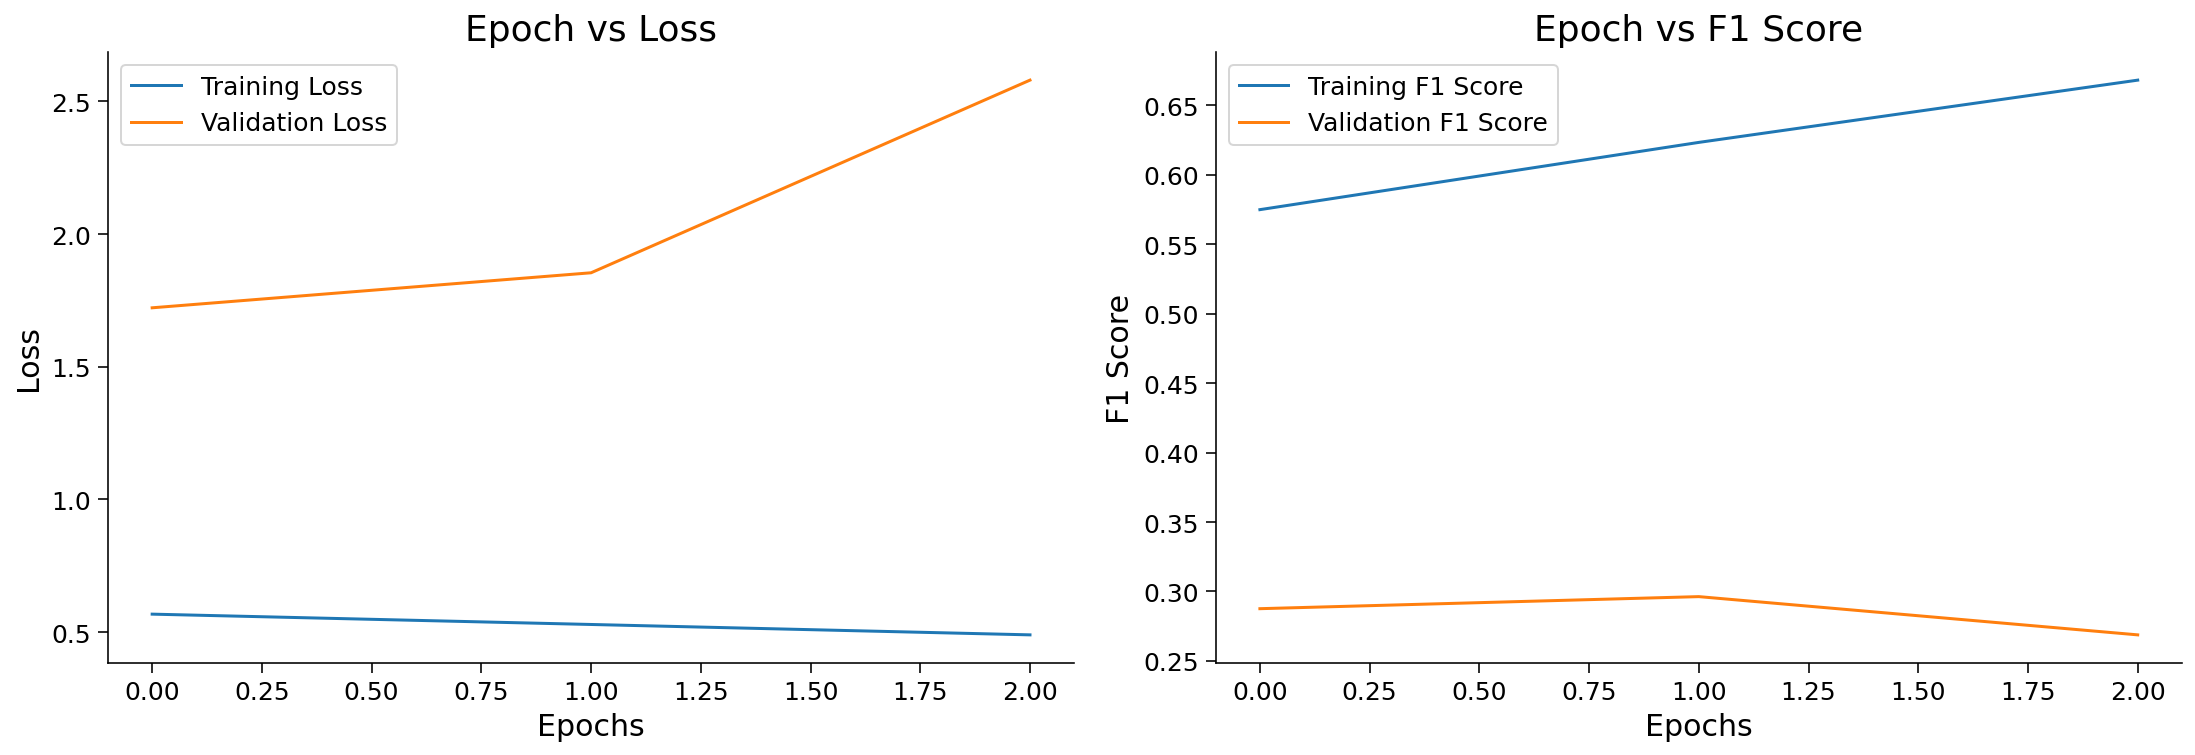

In [47]:
# plot the model loss and f1 across epochs
plot_loss_accuracy(train_loss, train_f1, validation_loss, validation_f1)

In [48]:
# calculate the performance on holdout test set
test_f1 = test(net, device, testing_loader)

In [49]:
print(test_f1)

0.1079242276525039
